In [1]:


from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

from tensorflow.keras.callbacks import Callback

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib



In [2]:
tf.__version__

'2.1.0'

In [3]:
import tensorflow_io as tfio

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
BATCH_SIZE = 16
IMG_HEIGHT = 1024
IMG_WIDTH = 1024
EPOCHS = 2
lr = 3e-4

CHANNELS =1
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
FILTER_SIZE = 3

In [6]:
val_data_dir = '/opt/AIStorage/PLAYGROUND/DICOMS/validation'
val_data_dir = pathlib.Path(val_data_dir)

data_dir = '/opt/AIStorage/PLAYGROUND/DICOMS/train'
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.dcm')))
image_count

3200

In [8]:
val_image_count = len(list(val_data_dir.glob('*/*.dcm')))
val_image_count

799

In [9]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

val_list_ds = tf.data.Dataset.list_files(str(val_data_dir/'*/*'))

In [10]:
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [11]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  label = -1
  if parts[-2] == 'negative':
    label = tf.constant([1.0, 0.0])
  else:
    label = tf.constant([0.0, 1.0])
  return label

In [36]:
def decode_img(img):
  print('type2',type(img))
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  
  img = tfio.image.decode_dicom_image(img, scale='auto', on_error='lossy', dtype=tf.dtypes.uint8)
  #img = tfio.image.decode_dicom_image(img,  dtype=tf.dtypes.uint16 )  
  print('1',img.shape)
    
  
  img = tf.image.convert_image_dtype(img, tf.float32)
  print('2',img.shape)
  
  img = tf.image.resize_with_pad(img, IMG_WIDTH, IMG_HEIGHT)
  print('3',img.shape)
    
  img = tf.squeeze(img)
  print('4',img.shape)
    
  img = tf.expand_dims(img,-1)
  print('5',img.shape)
  return img
  
  

In [37]:
def process_path(file_path):
  print('path',file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  #img = tf.io.read_file(file_path)
  img  = tf.io.read_file(file_path)
  
  img = decode_img(img)
  return img, label

In [38]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

path Tensor("args_0:0", shape=(), dtype=string)
type2 <class 'tensorflow.python.framework.ops.Tensor'>
1 (None, None, None, None)
2 (None, None, None, None)
3 (None, 1024, 1024, None)
4 <unknown>
5 <unknown>
path Tensor("args_0:0", shape=(), dtype=string)
type2 <class 'tensorflow.python.framework.ops.Tensor'>
1 (None, None, None, None)
2 (None, None, None, None)
3 (None, 1024, 1024, None)
4 <unknown>
5 <unknown>


In [39]:
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.ceil(val_image_count/BATCH_SIZE)

In [40]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (1024, 1024, 1)
Label:  [0. 1.]


Image shape:  (1024, 1024, 1)
Label:  [1. 0.]


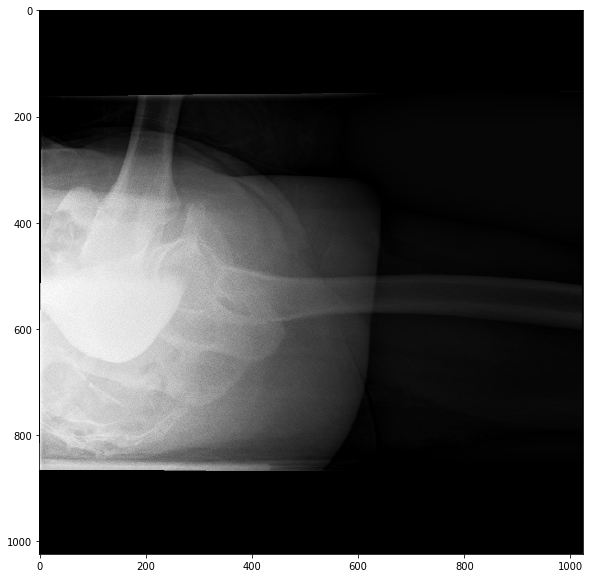

In [64]:
image = []
for image, label in val_labeled_ds.take(1):
  pixel_values = np.squeeze(image.numpy())
  rescaled = (255.0 / pixel_values.max() * (pixel_values - pixel_values.min())).astype(np.uint8)
  im = Image.fromarray(rescaled,'L')
  
  
  im.save("temp.png")
  image = image
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.rcParams['figure.figsize'] = [10, 10]
  plt.imshow(np.squeeze(image.numpy()), cmap='gray')

In [32]:
def prepare_for_training(ds, shuffle=True, cache=True, shuffle_buffer_size=4000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  if shuffle:
    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [33]:
train_ds = prepare_for_training(labeled_ds)

valid_ds = prepare_for_training(val_labeled_ds, shuffle=False)
#valid_ds = val_labeled_ds

#image_batch, label_batch = next(iter(train_ds))

In [34]:
class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
 

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            print('get lr error')
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            print('get momentum error')
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            print('set lr error')
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            print('set momentum error')
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [35]:

    
    initializer = tf.keras.initializers.he_normal()
    steps = np.ceil(image_count / BATCH_SIZE) * EPOCHS
    lr_schedule = OneCycleScheduler(lr, steps)

    optimizer = tf.keras.optimizers.SGD(lr=lr)
    #optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    #optimizer = tf.keras.optimizers.Adam()
    IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
    
    
    model = Sequential([
        Conv2D(64, FILTER_SIZE, padding='same', input_shape=IMG_SHAPE, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(64, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(384, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(384, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
        
        Conv2D(256, FILTER_SIZE, padding='same', kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(),
           
        Flatten(),
        #Dropout(0.15),
        
        Dense(2048, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        Dropout(0.5),
       
        
        Dense(1024, kernel_initializer=initializer),
        BatchNormalization(),
        ReLU(),
        Dropout(0.25),
        
        
        Dense(2, kernel_initializer=initializer)
    ])
    
    
    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc'])
    
    model.summary()
    
    history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=valid_ds, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_steps=VAL_STEPS_PER_EPOCH,
                    callbacks=[lr_schedule])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1024, 1024, 64)    640       
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024, 1024, 64)    256       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 1024, 1024, 64)    0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 512, 512, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 512, 512, 64)      256       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 512, 512, 64)     

ValueError: in converted code:

    /home/HEALTH/ejguillen/venv/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/HEALTH/ejguillen/venv/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home/HEALTH/ejguillen/venv/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected conv2d_8_input to have 4 dimensions, but got array with shape (None, None, 1024, 1024, None)


In [ ]:
lr_schedule.plot()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()